# **Projet de Classification d'Images - Livrable 1**

## **1. Introduction du projet**

Ce projet s'inscrit dans le cadre d'une solution de **classification d'images** pour l'entreprise TouNum, spécialisée dans la numérisation de documents. L'objectif principal est de développer un modèle de **réseau de neurones convolutif (CNN)** capable de distinguer automatiquement des photos d'autres types d'images (schémas, peintures, dessins, scans de textes, etc.). Cette classification permettra à l'entreprise d'automatiser le tri des images, améliorant ainsi l'efficacité des processus de traitement et de gestion de grandes quantités de données numérisées.

La problématique de la classification d'images est un sujet central dans le domaine du **deep learning**, notamment dans les contextes où les datasets sont hétérogènes, comme c'est le cas ici. Les images à classifier présentent des caractéristiques visuelles très différentes : les photos et les peintures peuvent partager des similarités complexes, tandis que les schémas ou les textes scannés sont visuellement distincts. L'enjeu est donc de concevoir un modèle suffisamment robuste pour non seulement distinguer ces différentes classes mais aussi généraliser à des données non vues.

Pour cela, nous allons nous appuyer sur un **modèle de réseau de neurones convolutif (CNN)**, une architecture qui a fait ses preuves pour les tâches de classification d'images, en raison de sa capacité à capturer efficacement les motifs locaux à différentes échelles. Dans ce projet, nous nous concentrons sur une classification binaire qui vise à distinguer les photos du reste des images. Cette approche sera ensuite étendue vers des classifications plus complexes, y compris une différenciation entre peintures et photos.

Le modèle sera implémenté en **Python** à l'aide du framework **TensorFlow**, largement utilisé pour le développement de modèles de deep learning. Pour garantir une performance optimale, des techniques telles que l'**augmentation des données**, la **régularisation** et l'utilisation de **callbacks** (comme l'early stopping et le checkpointing) seront explorées. Nous examinerons également les performances du modèle via des métriques comme l'**accuracy** et la **perte**, en traçant leur évolution pendant l'entraînement.

En fin de compte, ce projet vise à fournir à TouNum une solution automatisée qui s'intègre dans leur chaîne de production, tout en offrant une base solide pour des développements futurs dans des domaines connexes comme l'**annotation d'images** ou le **captioning automatique**.

## **2. Préparation des données**

### **2.1. Importation des bibliothèques**
Dans cette étape, nous importons un ensemble de bibliothèques Python nécessaires pour l'entraînement du modèle et la manipulation des données :

- `warnings`: Pour filtrer les avertissements non critiques afin de rendre les sorties du notebook plus lisibles.
- `os`: Permet de gérer les opérations liées au système d'exploitation, telles que la création de dossiers et la gestion des chemins.
- `datetime`: Utilisée pour générer des horodatages et organiser les fichiers de logs et de modèles.
- `zipfile`: Pour manipuler les fichiers compressés au format `.zip`, utile pour décompresser les datasets.
- `tqdm`: Permet d'afficher des barres de progression pour suivre les opérations longues.
- `gdown`: Utilisé pour télécharger des fichiers à partir de Google Drive (pratique pour récupérer des datasets).
- `glob`: Permet de trouver des fichiers et des répertoires en fonction de motifs spécifiques.
- `matplotlib.pyplot`: La bibliothèque de visualisation pour tracer les courbes et graphiques nécessaires à l'analyse des résultats.
- `tensorflow`: La bibliothèque principale utilisée pour créer et entraîner les réseaux de neurones.

In [ ]:
import warnings, os, datetime, zipfile, tqdm, gdown, glob, random, shutil, pytz
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### **2.2. Configuration des chemins et des répertoires**

Afin de bien organiser le projet, plusieurs chemins de fichiers et répertoires sont créés pour stocker les datasets, les modèles et les logs d'entraînement. Cela facilite la gestion des fichiers et permet de garder une structure claire.

In [10]:
timezone = pytz.timezone('Europe/Paris')
now = datetime.datetime.now(timezone).strftime('%Y.%m.%d-%H.%M.%S')

project_path = os.getcwd()

is_docker = os.environ.get('IS_DOCKER', False)

if is_docker:
    print("Docker usage detected")
    project_path = f"{project_path}/livrable_1"
else:
    print("Normal usage detected")

paths = {
    "data_path": f"{project_path}/data",
    "train_data_path": f"{project_path}/data/train",
    "validation_data_path": f"{project_path}/data/validation",
    "unsorted_validation_data_path": f"{project_path}/data/validation/unsorted",
    "sorted_validation_data_path": f"{project_path}/data/validation/sorted",
    "model_path": f"{project_path}/models",
    "checkpoint_path": f"{project_path}/weights/model_early",
    "log_path": f"{project_path}/logs/fit/{now}_model"
}

paths_to_delete = [
    "unsorted_validation_data_path",
    "sorted_validation_data_path"
]

for key, path in paths.items():
    if key in paths_to_delete and os.path.exists(path):
        print(f"Deleting {path}")
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

image_h = 224
image_w = 224
batch_s = 32

Docker usage detected
Deleting /tf/ProjetDeepLearning/livrable_1/data/validation/unsorted
Deleting /tf/ProjetDeepLearning/livrable_1/data/validation/sorted


### **2.3. Téléchargement et extraction du dataset**

Pour entraîner le modèle de classification, nous avons besoin d'un dataset contenant les images à classer. Le dataset est stocké dans un fichier compressé `.zip` disponible sur Google Drive. La fonction suivante télécharge ce dataset, si nécessaire, et l'extrait dans le répertoire approprié.

In [14]:
def download_dataset(force=False):
    
    dataset_path = f"{paths['train_data_path']}/dataset.zip"

    if os.path.exists(dataset_path) and force == False:
        print("Dataset already downloded")
    else:
        print("Downloading dataset")
        url = 'https://drive.google.com/uc?export=download&id=1vhNmk5omNcX3g9enqETvFR_2vdVONsxo'
        gdown.download(url, dataset_path, quiet=False)
    
    if len(os.listdir(paths['train_data_path'])) == 6 and force == False:
        print("Dataset already exported")
    else:
        print("Exporting dataset")
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            files = zip_ref.infolist()
            with tqdm.tqdm(total=len(files), desc="Décompression", unit="fichier") as pbar:
                    for file in files:
                        zip_ref.extract(file, paths['train_data_path'])
                        pbar.update(1)
            zip_ref.extractall(paths['train_data_path'])
            print(f"Dataset downloaded {paths['train_data_path']}")
        
download_dataset()

Dataset already downloded
Dataset already exported


### **2.4. Vérification de l'intégrité des images**

Il est important de s'assurer que toutes les images du dataset sont valides avant de les utiliser pour l'entraînement du modèle. Des fichiers corrompus ou non valides pourraient causer des erreurs lors du chargement ou de l'entraînement du modèle. La fonction suivante permet de parcourir toutes les images du dataset et de vérifier si elles peuvent être correctement lues par TensorFlow.

In [15]:
def check_images_in_dataset(dataset_path):
    img_paths = glob.glob(os.path.join(dataset_path, '*/*.*'))

    for img_path in tqdm.tqdm(img_paths, desc="Checking images"):
        try:
            img_bytes = tf.io.read_file(img_path)
            tf.io.decode_image(img_bytes)
            
        except tf.errors.InvalidArgumentError as e:
            print(f"Found bad file: {img_path}. Removing it.")
            os.remove(img_path)

check_images_in_dataset(paths['train_data_path'])

### **2.5. Chargement des données d'entraînement et de test**

Pour entraîner et évaluer le modèle, nous avons besoin de charger les images depuis les répertoires dans lesquels elles sont stockées. TensorFlow propose une méthode pratique avec `image_dataset_from_directory` qui permet de charger directement les images depuis un répertoire et de les transformer en un format compatible avec les réseaux de neurones.

In [18]:
def create_validation_set(num_files_to_copy=20):
    
    files = glob.glob('')
    for file in files:
        os.remove(file)
        
    for folder in os.listdir(paths['train_data_path']):
        if folder.endswith(".zip"):
            continue
        folder_path = os.path.join(paths['train_data_path'], folder)
        files = os.listdir(folder_path)
        files_to_copy = random.sample(files, num_files_to_copy)
        for file in files_to_copy:
            src_file = os.path.join(folder_path, file)
            dest_file = os.path.join(paths['unsorted_validation_data_path'], file)
            shutil.copy2(src_file, dest_file)

create_validation_set()

In [20]:
train_set, test_set = tf.keras.preprocessing.image_dataset_from_directory(
    paths['train_data_path'],
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s,
    labels="inferred",
    label_mode="int"
)

Found 32755 files belonging to 5 classes.
Using 26204 files for training.
Using 6551 files for validation.


I0000 00:00:1728303736.715073      31 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728303736.858078      31 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728303736.858126      31 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728303736.860528      31 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728303736.860571      31 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

### **2.6. Extraction des noms des classes**

Après avoir chargé les datasets d'entraînement et de validation, nous pouvons extraire les noms des classes à partir du dataset. TensorFlow fournit automatiquement les noms de classes en fonction des sous-dossiers du répertoire de données. Cela nous permet de mieux comprendre la répartition des catégories dans les données.

In [22]:
class_names = test_set.class_names
class_num = len(class_names)
print(class_names)

['painting', 'photo', 'schematics', 'sketch', 'text']


### **2.7. Prétraitement des images**

Avant d'envoyer les images au modèle de réseau de neurones pour l'entraînement, il est important de les préparer de manière cohérente. Cette étape consiste à redimensionner toutes les images à une taille commune tout en conservant leur ratio d'aspect. Cela garantit que les images ont des dimensions uniformes (224x224 pixels) sans distorsion, grâce à l'ajout de padding si nécessaire.

In [23]:
def preprocess_image(image, label):
    # Resize the image with the same ratio
    image = tf.image.resize_with_pad(image, image_h, image_w)
    return image, label

train_set = train_set.map(preprocess_image)
test_set = test_set.map(preprocess_image)

Le choix de redimensionner toutes les images à une taille de 224x224 pixels est motivé par plusieurs considérations :

- Compatibilité avec les architectures pré-entraînées : De nombreuses architectures CNN populaires (comme VGG16, ResNet, Inception) ont été initialement entraînées sur des images de cette dimension. Cela facilite l'intégration éventuelle du transfert d'apprentissage, où l'on peut utiliser des modèles pré-entraînés pour améliorer les performances ou accélérer l'entraînement.

- Équilibre entre détail et performance :
    - Détail suffisant : Une résolution de 224x224 pixels est suffisamment élevée pour conserver les détails visuels essentiels qui permettent de distinguer les différentes classes d'images.
    
    - Efficacité computationnelle : Des images de plus haute résolution augmenteraient significativement le temps d'entraînement et les besoins en mémoire, sans nécessairement apporter de gains proportionnels en performance.

- Uniformisation des données : En standardisant la taille des images, on s'assure que le modèle reçoit des entrées cohérentes, ce qui simplifie le traitement par lots (batch processing) et évite les problèmes liés à des dimensions variables.

### **2.8. Visualisation des images**

Avant d'entraîner le modèle, il est utile de visualiser quelques exemples d'images du dataset pour vérifier que le chargement et le prétraitement des données ont été correctement effectués. La fonction `print_img()` affiche un échantillon d'images avec leurs étiquettes respectives.

Image shape:  (32, 224, 224, 3)
Labels shape:  (32,)


2024-10-07 12:22:27.938974: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


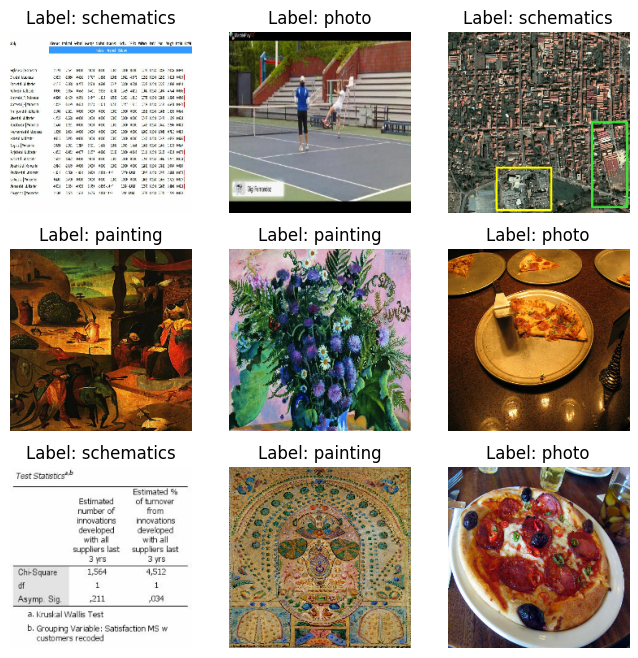

In [24]:
def print_img(dataset, num_images=9):
    plt.figure(figsize=(8, 8))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Label: {class_names[labels[i]]}")
            plt.axis("off")
    plt.show()
        
images, labels = iter(train_set).next()
print("Image shape: ", images.shape)
print("Labels shape: ", labels.shape)
print_img(train_set, 9)

### **2.9. Optimisation des Performances des Données**

Pour garantir un entraînement efficace et éviter les goulets d'étranglement en termes de performances, il est essentiel d'optimiser non seulement le modèle, mais aussi le traitement des données. Cette section se concentre sur l’utilisation de techniques spécifiques dans TensorFlow pour maximiser l’efficacité du flux de données pendant l’entraînement, notamment en gérant le cache, le préchargement et le mélange des données. Ces optimisations permettent de réduire les temps d’attente pendant l’entraînement tout en garantissant une meilleure généralisation du modèle.

#### **1. AUTOTUNE**

L’argument `AUTOTUNE` de TensorFlow permet d’ajuster dynamiquement la taille du buffer de préchargement des données. Le but est de déterminer automatiquement les paramètres optimaux pour le pipeline de données, en fonction des ressources disponibles sur la machine, comme la mémoire et les cœurs du processeur.

- **Pourquoi utiliser AUTOTUNE ?**
  
  En pratique, le processus d'entraînement d'un modèle de deep learning repose non seulement sur la puissance de calcul du GPU ou du CPU, mais aussi sur la rapidité à laquelle les données peuvent être transmises au modèle. Si les données ne sont pas prêtes à temps (bottleneck d'I/O), le GPU pourrait rester inactif, ralentissant ainsi l'entraînement. `AUTOTUNE` ajuste automatiquement le nombre de processus parallèles pour précharger et traiter les données, permettant ainsi d’éviter ces retards.

- **Avantages :**
  
  - **Optimisation des ressources** : En ajustant dynamiquement les ressources allouées, `AUTOTUNE` permet d’utiliser pleinement la puissance de calcul de la machine sans nécessiter de réglages manuels.

  - **Réduction des goulets d'étranglement** : En préchargeant les données de manière optimisée, `AUTOTUNE` garantit que le modèle n’attend jamais les données pendant l’entraînement, maximisant ainsi l’utilisation des GPU/CPU.

#### **2. Mise en Cache des Données**

L’instruction `.cache()` stocke les données prétraitées en mémoire après leur premier passage. Cela permet d’éviter de relire et de recharger les images du disque à chaque époque d’entraînement, une opération coûteuse en temps.

- **Pourquoi la mise en cache est-elle cruciale ?**
  
  Lorsque les données sont lues directement depuis le disque dur à chaque époque, cela introduit une latence importante due à l’I/O (Input/Output). En mettant les données en cache dans la mémoire, nous éliminons cette latence pour les époques suivantes, ce qui réduit drastiquement les temps d’entraînement, surtout si le dataset est volumineux.

- **Avantages :**
  
  - **Gain de temps** : En éliminant la nécessité de lire les données du disque dur à chaque époque, la mise en cache permet de réduire considérablement les temps d'entraînement, en particulier pour les datasets volumineux.

  - **Stabilité** : La mise en cache garantit également que les données restent cohérentes entre les époques, évitant des problèmes liés à des lectures aléatoires ou à des erreurs d'I/O.

#### **3. Mélange Aléatoire des Données**

Le mélange des données avant chaque époque est un processus essentiel pour garantir que le modèle ne voit jamais les données dans un ordre fixe, ce qui améliorerait artificiellement ses performances et pourrait entraîner un surapprentissage.

- **Pourquoi mélanger les données ?**
  
  Si les données sont toujours présentées au modèle dans le même ordre, il pourrait mémoriser des séquences spécifiques ou se concentrer de manière inégale sur certaines parties du dataset, ce qui compromettrait sa capacité à généraliser sur des données non vues. Le mélange aléatoire des données (`shuffle()`) permet d'assurer que chaque époque présente les données dans un ordre différent, réduisant ainsi la corrélation entre les échantillons successifs.

- **Paramètre de taille du buffer (`1000`) :**
  
  Le nombre `1000` indique la taille du buffer utilisé pour mélanger les données. Ce buffer contient un sous-ensemble des données qui est mélangé avant d'être passé au modèle. Le choix de la taille du buffer est important : un buffer trop petit pourrait ne pas mélanger efficacement les données, tandis qu’un buffer trop grand pourrait être coûteux en mémoire. Le choix de `1000` est un compromis entre ces deux extrêmes, garantissant un mélange efficace sans surcharge mémoire.

- **Avantages :**
  
  - **Meilleure généralisation** : En présentant les données dans un ordre aléatoire à chaque époque, le modèle est moins susceptible de mémoriser des séquences particulières du dataset, favorisant ainsi une meilleure généralisation.

  - **Réduction du biais d'ordre** : Un mélange efficace des données permet d'éviter le biais d’ordre, où le modèle pourrait surévaluer ou sous-évaluer certaines classes en raison de leur positionnement dans le flux de données.

#### **Rôle Combiné des Optimisations**

L'utilisation combinée de `AUTOTUNE`, de la mise en cache et du mélange aléatoire des données permet de maximiser l'efficacité du pipeline de données. Ces optimisations réduisent les goulets d'étranglement dus à l’I/O et garantissent que le modèle reçoit les données de manière fluide et diversifiée à chaque époque. En conséquence, non seulement le temps d'entraînement est réduit, mais la capacité du modèle à généraliser sur de nouvelles données est également améliorée.

In [25]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

### **2.10. Augmentation des Données**

L’augmentation des données (**data augmentation**) est une technique essentielle pour améliorer la robustesse et la capacité de généralisation du modèle, en particulier lorsque le dataset est de taille limitée ou que certaines classes sont sous-représentées. Cette méthode repose sur l'application de transformations aléatoires aux images d'entraînement, créant ainsi des variantes artificielles tout en conservant les propriétés essentielles des données. Cela permet au modèle d’apprendre à identifier les caractéristiques des images dans des conditions variées et réalistes.

#### Pourquoi l'augmentation des données est-elle nécessaire ?

1. **Amélioration de la généralisation**
   
   Un des principaux défis en deep learning est d'assurer que le modèle ne se contente pas de mémoriser les données d'entraînement, mais qu'il puisse aussi généraliser à des données qu’il n’a jamais vues. L'augmentation des données simule cette variabilité en créant des versions modifiées des images existantes, ce qui augmente virtuellement la taille du dataset et diversifie les exemples que le modèle voit durant l’entraînement.

2. **Prévention du surapprentissage (overfitting)**
   
   Lorsque le dataset est limité, il est facile pour un modèle puissant comme un CNN de surapprendre les détails spécifiques des images d'entraînement, conduisant à une mauvaise performance sur les données de validation ou en production. En introduisant des transformations aléatoires, l’augmentation des données rend le modèle moins susceptible de mémoriser les exemples spécifiques et l'oblige à apprendre des représentations plus robustes et généralisables.

3. **Enrichissement du dataset**
   
   L'augmentation des données permet d'introduire une diversité dans les images, en simulant des conditions que le modèle pourrait rencontrer dans des situations réelles, comme des variations de lumière, des rotations, des zooms, etc. Cela est particulièrement utile dans le cas d'un dataset hétérogène ou lorsque certaines classes d'images sont peu représentées.

#### Techniques Utilisées pour l'Augmentation des Données

Dans ce projet, plusieurs techniques d'augmentation des données sont mises en œuvre, chacune ayant pour objectif de simuler des transformations réalistes des images tout en préservant leur signification sémantique :

1. **RandomFlip (Renversement horizontal)**
   
   Le renversement horizontal est l'une des méthodes d'augmentation les plus simples et les plus efficaces. Il permet de doubler virtuellement la taille du dataset en générant des versions symétriques des images. Cette technique est particulièrement utile dans les tâches où l'orientation gauche/droite d'un objet ou d'une scène ne change pas la classe à laquelle il appartient (par exemple, des paysages ou des bâtiments). En introduisant des images renversées, le modèle apprend à être moins sensible à la symétrie des objets, améliorant ainsi sa capacité de généralisation.

2. **RandomRotation (Rotation aléatoire)**
   
   La rotation aléatoire des images, dans une plage de ±10%, permet de rendre le modèle invariant à l'orientation des objets. Ceci est crucial dans un contexte de classification d'images, où l'angle de prise de vue peut varier. La rotation permet au modèle de reconnaître les objets sous des angles différents, ce qui est essentiel dans des scénarios où les images peuvent ne pas être parfaitement alignées (comme dans le cas de documents numérisés de manière non uniforme).

3. **RandomZoom (Zoom aléatoire)**
   
   Le zoom aléatoire de ±10% permet de simuler des variations dans la distance entre l'objet et la caméra. Cela aide le modèle à apprendre à reconnaître les objets ou les motifs à différentes échelles, en renforçant sa robustesse face à des images où l'objet occupe plus ou moins d’espace dans le cadre. Cette transformation est particulièrement utile pour éviter que le modèle ne devienne trop dépendant d'une certaine échelle lors de l'apprentissage.

#### Avantages de l'augmentation des données utilisée

Les trois techniques d'augmentation utilisées dans ce projet visent à enrichir le dataset en simulant des variations courantes dans des contextes réels, tout en maintenant la pertinence sémantique des images. L'augmentation des données est essentielle pour :

- **Réduire le surapprentissage** : En créant des images modifiées à partir des exemples d'entraînement, le modèle apprend à reconnaître les objets dans diverses conditions, ce qui réduit la dépendance à des exemples spécifiques et améliore sa capacité de généralisation.
  
- **Améliorer la robustesse aux transformations** : Les transformations appliquées (flip, rotation, zoom) simulent des conditions réalistes que le modèle pourrait rencontrer en production, rendant le modèle plus robuste aux variations d'orientation et d'échelle dans les images.

- **Augmenter virtuellement la taille du dataset** : Avec seulement trois transformations, le dataset est virtuellement agrandi, ce qui permet au modèle de s’entraîner sur un ensemble de données plus diversifié sans avoir besoin de collecter des images supplémentaires.

In [26]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ]
)

### **3.1. Fonction `create_model`**

Les réseaux de neurones convolutifs (CNN) sont largement reconnus comme l’architecture de référence pour les tâches de classification d'images en **deep learning**. Leur conception, qui exploite les relations spatiales entre les pixels, est parfaitement adaptée au traitement des données visuelles. Dans ce projet, la fonction `create_model` implémente un modèle CNN, optimisé pour classifier efficacement les images numérisées fournies.

#### Pourquoi utiliser un CNN pour ce projet ?

1. **Extraction automatique des caractéristiques**
   Les CNN se distinguent par leur capacité à apprendre des représentations hiérarchiques directement à partir des données d'entrée, sans nécessiter de prétraitement manuel des caractéristiques. À travers les couches convolutionnelles, le modèle extrait automatiquement des motifs de plus en plus complexes : les premières couches capturent des motifs simples comme les bords ou les textures, tandis que les couches plus profondes apprennent des caractéristiques globales telles que la forme ou l'objet lui-même. Cette approche est particulièrement avantageuse pour notre projet, où les images peuvent être très variées en termes de contenu (photos, schémas, peintures, etc.).

2. **Invariance aux translations et aux déformations**
   L’un des grands avantages des CNN réside dans leur invariance spatiale. Grâce à l'utilisation de couches de **pooling** et de filtres partagés, les CNN sont capables de détecter des motifs visuels même lorsqu’ils subissent des transformations géométriques comme des rotations, des redimensionnements ou des translations. Pour ce projet, où les images numérisées peuvent être variées en termes d'orientation ou de perspective, cette capacité à identifier des motifs de manière robuste est essentielle.

3. **Efficacité computationnelle**
   Les CNN exploitent le partage de poids, ce qui permet d'optimiser le nombre de paramètres à entraîner. Contrairement aux réseaux entièrement connectés (fully connected), où chaque neurone est connecté à tous les autres, les CNN utilisent des filtres qui se déplacent localement sur l'image, réduisant ainsi la complexité. Cela permet d'entraîner des modèles plus profonds et plus puissants sans nécessiter une quantité excessive de mémoire ou de temps de calcul. Cette efficacité est critique dans un contexte de traitement à grande échelle, comme celui de ce projet.

4. **Succès éprouvé dans la classification d'images**
   Les CNN ont prouvé leur efficacité dans de nombreux benchmarks de classification d'images, y compris des jeux de données très complexes comme **ImageNet**. Les architectures CNN sont à la base des meilleures performances dans des compétitions internationales, confirmant leur capacité à généraliser sur des données visuelles variées. L’utilisation d’un CNN pour ce projet est donc justifiée pour garantir une haute précision et une robustesse dans la classification des images.

#### Détails du Modèle CNN Implémenté

La fonction `create_model` est structurée de la manière suivante :

- **Couches Convolutionnelles (Conv2D)** : Chaque couche convolutionnelle applique plusieurs filtres qui balayent l’image pour détecter des motifs spécifiques. Les premières couches capturent des caractéristiques simples comme les bords et les textures, tandis que les couches plus profondes extraient des informations plus complexes.
  
- **Couches de Pooling (MaxPooling2D)** : Ces couches réduisent la dimension des cartes de caractéristiques tout en conservant les informations les plus importantes. Cela permet de diminuer le nombre de paramètres, rendant le modèle plus efficace sans perte significative de performance. De plus, le pooling introduit une invariance aux petites translations des objets dans les images.

- **Couches Fully Connected (Dense)** : Ces couches, situées en fin de réseau, transforment les caractéristiques extraites par les couches convolutionnelles en un vecteur de classification. Ces couches apprennent à combiner les informations locales pour effectuer une classification globale de l'image.

- **Fonctions d'activation** :
  - **ReLU** (Rectified Linear Unit) est utilisée après chaque couche convolutionnelle. Cette fonction d'activation introduit de la non-linéarité, ce qui permet au modèle de capturer des relations complexes dans les données.
  
  - **Softmax** est utilisée en sortie pour convertir les prédictions en probabilités, permettant ainsi de classifier les images en fonction de leur classe.

#### Choix de la Fonction de Perte : **Cross-Entropy Categorical**

La **fonction de perte** utilisée pour ce modèle est la **cross-entropie catégorielle**. Elle est particulièrement adaptée aux tâches de classification multi-classes comme celle-ci, car elle mesure la distance entre la distribution des probabilités prédites par le modèle et les étiquettes réelles. En minimisant cette fonction de perte, le modèle est entraîné à améliorer la précision de ses prédictions, ajustant ses poids à chaque itération pour réduire l’erreur sur les données d'entraînement.

#### Choix de l’Optimiseur : **Adam**

L’optimiseur **Adam** a été sélectionné pour ce projet en raison de ses nombreux avantages par rapport aux algorithmes d'optimisation plus classiques comme **SGD (Stochastic Gradient Descent)**. Adam combine la descente de gradient avec moment et l'adaptation des taux d'apprentissage pour chaque paramètre, ce qui en fait un optimiseur efficace, en particulier dans des environnements où les gradients peuvent être bruités ou non stationnaires, comme c’est souvent le cas dans les tâches de classification d'images.

- **Adaptation du taux d'apprentissage** : Contrairement à SGD qui utilise un taux d'apprentissage constant, Adam ajuste dynamiquement le taux d'apprentissage pour chaque paramètre, permettant ainsi une convergence plus rapide et plus stable.

- **Résistance aux gradients bruyants** : Adam utilise deux moments (le moment de premier ordre pour la moyenne des gradients et le moment de second ordre pour la variance des gradients), ce qui permet d'atténuer l’effet des gradients bruyants ou mal estimés. Cela est particulièrement utile lorsque les données d'entraînement sont hétérogènes, comme dans le dataset de ce projet.
  
Dans la littérature, Adam est souvent reconnu comme étant un choix robuste pour les problèmes de classification d’images, en particulier dans les scénarios où le dataset présente des images bruitées ou des classes déséquilibrées, comme c’est le cas ici.

In [27]:
def create_model(input_shape=(image_h, image_w, 3)):
    model = tf.keras.models.Sequential()
    
    data_augmentation = tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
        ]
    )
    
    model.add(tf.keras.layers.Rescaling(1./255, input_shape=input_shape))
    
    model.add(data_augmentation)
        
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding="same"))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(128, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(class_num, activation='softmax'))
    
    loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer="adam", loss=loss_function, metrics=['accuracy'])
    
    model.summary()
    
    return model

model = create_model()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,446,885 (24.59 MB)

 Trainable params: 6,446,885 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

### **3.2. Définition des Callbacks**

Les **callbacks** dans TensorFlow/Keras permettent d'intégrer des actions spécifiques pendant le processus d'entraînement du modèle. Dans ce projet, nous utilisons trois types de callbacks qui jouent un rôle crucial dans l'optimisation de l'entraînement et la surveillance des performances :

#### 1. **ModelCheckpoint**

Le **ModelCheckpoint** est utilisé pour sauvegarder périodiquement les poids du modèle. Plus précisément, il enregistre les poids du modèle après chaque époque où une amélioration est observée sur les données de validation, en fonction d’une métrique donnée (par exemple, la perte ou l’accuracy sur l'ensemble de validation). Ce mécanisme est particulièrement important pour plusieurs raisons :

- **Conserver les meilleures performances** : Seules les meilleures versions du modèle sont sauvegardées, évitant la dégradation due au surentraînement.

- **Prévenir les pertes de progrès** en cas d'interruption.

- **Limiter le surapprentissage** en enregistrant uniquement les poids correspondant aux meilleures performances.

#### 2. **TensorBoard**

Le **callback TensorBoard** permet de générer des journaux d'entraînement qui peuvent être visualisés avec l'outil **TensorBoard**. TensorBoard est un outil essentiel pour le diagnostic et la surveillance en temps réel de l’entraînement, car il offre plusieurs avantages techniques :

- **Visualiser l’évolution des performances** (perte, précision) sur les données d’entraînement et de validation.

- **Suivre les gradients et poids du modèle** pour détecter des anomalies comme le vanishing gradient.

- **Analyser les temps d’entraînement** pour optimiser les performances.

#### 3. **EarlyStopping**

Le callback **EarlyStopping** est utilisé pour arrêter automatiquement l'entraînement lorsque les performances sur le jeu de validation cessent de s'améliorer après un certain nombre d’époques consécutives (défini par le paramètre `patience`). Cette technique repose sur l'idée qu'après un certain point, continuer l'entraînement n'améliore plus les performances générales du modèle et risque même de le dégrader (surapprentissage). Les raisons principales d'utiliser EarlyStopping sont les suivantes :

- **Éviter le surentraînement** et améliorer la généralisation.

- **Réduire le temps d'entraînement** en stoppant avant saturation.

- **Simplifier l’ajustement manuel** des époques d’entraînement.

#### **Rôle Combiné des Callbacks**

L'utilisation combinée de **ModelCheckpoint**, **EarlyStopping** et **TensorBoard** crée un écosystème de surveillance et d'optimisation durant l’entraînement du modèle. **ModelCheckpoint** garantit que les meilleurs poids sont sauvegardés, même si le modèle commence à surapprendre. **EarlyStopping** arrête automatiquement l’entraînement lorsqu'une stagnation est détectée, optimisant ainsi la généralisation tout en réduisant la consommation de ressources. Enfin, **TensorBoard** offre une visualisation en temps réel de l'entraînement, permettant d'identifier rapidement les problèmes potentiels, qu'ils soient liés à la convergence, au surapprentissage, ou à des inefficacités computationnelles.

In [30]:
def get_callbacks():    
    # Create a callback that saves the model's weights
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=paths['checkpoint_path'] + "/weights-epoch-{epoch:02d}-{val_loss:.2f}.weights.h5",
        save_weights_only=True,
        save_best_only=True,
        verbose=1
    )
    
    # Tensorboard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=paths['log_path'],
        histogram_freq=1,
        write_graph=True,
        write_images=True,
        update_freq='epoch',
        profile_batch=0,
        embeddings_freq=0
    )
    
    # Early stopping
    early_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=4,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False,
        start_from_epoch=0
    )

    return [checkpoint_callback, tensorboard_callback, early_callback]

### **3.3. Entraînement du modèle**

Maintenant que le modèle est défini et compilé, nous pouvons procéder à l'entraînement. Dans cette étape, nous entraînons le modèle en utilisant le dataset d'entraînement tout en évaluant ses performances sur le dataset de validation à chaque époque. Nous utilisons également les callbacks définis précédemment pour sauvegarder les meilleurs poids, suivre l'entraînement avec TensorBoard, et arrêter l'entraînement de manière anticipée si nécessaire.

Les paramètres d'entraînement :

- **Nombre d'époques (`epochs`)** : Le modèle est entraîné pendant 10 époques, mais cela peut être ajusté en fonction des besoins du projet et des performances observées.
- **Callbacks** : Les callbacks définis précédemment (sauvegarde des poids, TensorBoard, et EarlyStopping) sont activés pendant l'entraînement pour surveiller et optimiser le processus.
- **Sauvegarde du modèle** : Une fois l'entraînement terminé, le modèle complet est sauvegardé sous forme de fichier `.keras`.



In [33]:
def run_model(model, epochs, load_path=None):
    if load_path is not None:
        history = model.load_weights(load_path)
        return history
    else:
        history = model.fit(
            train_set,
            epochs=epochs, 
            validation_data=test_set,
            callbacks=get_callbacks()
        )
        model.save(f"{paths['model_path']}/model.keras")
        return history

history = run_model(
    model,
    epochs=10
)

819/819 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7627 - loss: 0.5727
Epoch 1: val_loss improved from inf to 0.51056, saving model to /tf/ProjetDeepLearning/livrable_1/weights/model_early/weights-epoch-01-0.51.weights.h5
819/819 ━━━━━━━━━━━━━━━━━━━━ 96s 117ms/step - accuracy: 0.7627 - loss: 0.5727 - val_accuracy: 0.7965 - val_loss: 0.5106


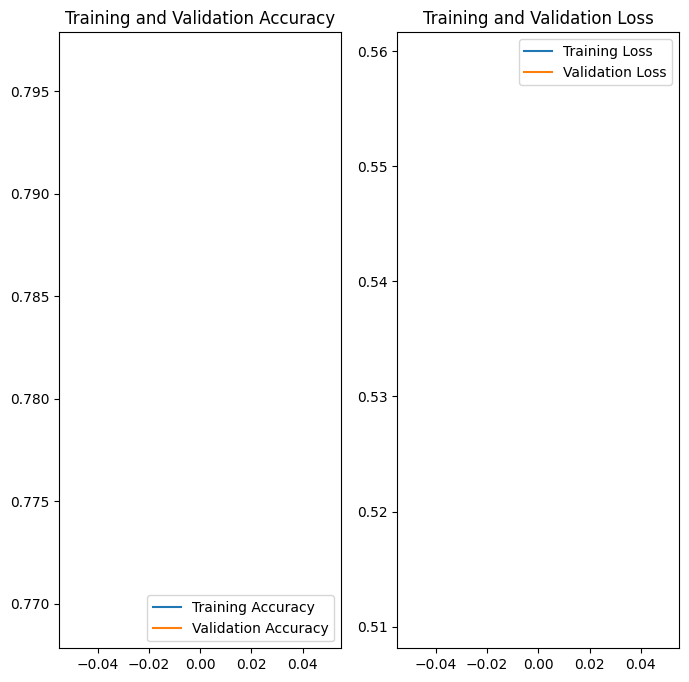

In [34]:
# Récupération des métriques d'entraînement et de validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Création de la plage d'époques
epochs_range = range(len(acc))

# Création de la figure
plt.figure(figsize=(8, 8))

# Graphique de précision
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Graphique de perte
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Affichage
plt.show()

Les résultats montrent une amélioration continue de la précision sur les données d'entraînement au fil des époques, ce qui indique que le modèle apprend bien les caractéristiques des données. Cependant, la précision de validation commence à stagner après l’époque 5, suggérant un début de sur-apprentissage. L’utilisation de techniques de régularisation supplémentaires, comme l’ajout de dropout ou l’augmentation des données, pourrait permettre d’atténuer ce phénomène.

In [35]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    return img_array

def is_photo(model, img_path):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    photo_index = class_names.index('photo')
    return prediction[0][photo_index]

def sort_images(model):
    for img_file in os.listdir(paths['unsorted_validation_data_path']):
        img_path = os.path.join(paths['unsorted_validation_data_path'], img_file)
        
        if os.path.isfile(img_path):
            if is_photo(model, img_path):
                shutil.copy2(img_path, os.path.join(paths['sorted_validation_data_path'], img_file))
                print(f"Image {img_file} détectée comme une photo. Copiée dans le dossier photo.")
            else:
                print(f"Image {img_file} non détectée comme une photo.")
                
sort_images(model)

W0000 00:00:1728304265.230090      84 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728304265.311135      84 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728304265.313123      84 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728304265.316382      84 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728304265.320063      84 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728304265.338829      84 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728304265.340482      84 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728304265.341482      84 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728304265.345315      84 gp

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


W0000 00:00:1728304265.480815      84 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728304265.501957      84 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728304265.502963      84 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728304265.503993      84 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728304265.504945      84 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728304265.505931      84 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728304265.506933      84 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728304265.508080      84 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728304265.509334      84 gp

Image 030_1_1_sz1.jpg détectée comme une photo. Copiée dans le dossier photo.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image 064_1_1_sz1.jpg détectée comme une photo. Copiée dans le dossier photo.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image 087_1_1_sz1.jpg détectée comme une photo. Copiée dans le dossier photo.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image 1468.png détectée comme une photo. Copiée dans le dossier photo.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image 1476.png détectée comme une photo. Copiée dans le dossier photo.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image 1497.png détectée comme une photo. Copiée dans le dossier photo.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image 176_1_1_sz1.jpg détectée comme une photo. Copiée dans le dossier photo.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image 195.png détectée comme une photo. Copiée dans le dossier photo.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Image 269_1_1_sz1.jpg détectée comme une photo. Copiée dans le dossier photo.
1/1 ━━━━━━━━━━━━━━━━━━━